In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as scs
import scipy.linalg as spla

import koma.oma
import koma.plot
import koma.clustering

In [2]:
parquet_file = r'./data/data_synced.parquet'
df = pd.read_parquet(parquet_file)

df_filtered = df.drop(['T1E_x', 'T1E_y', 'T1E_z'], axis=1)
df_filtered = df_filtered.drop(df.index[0:16*9*3600+30000])
df_filtered = df_filtered.drop(df.index[-1])
df_filtered = df_filtered.drop(df.index[16*10*3600:-1])

acceleration_data = df_filtered.to_numpy()

fs = 16
t = np.arange(0, len(acceleration_data))

acceleration_data = scs.detrend(acceleration_data, axis=0)

In [3]:
nperseg = 1000
zp = 8
nfft =  nperseg * zp

Sxy = np.array([[scs.csd(ch1, ch2, fs, nperseg=nperseg, nfft=nfft)[1] for ch1 in acceleration_data.T] for ch2 in acceleration_data.T])

Sxx = np.trace(Sxy)

In [4]:
f, _ = scs.welch(acceleration_data[:,0], fs=fs, nperseg=nperseg, nfft=nfft)
# channels = acceleration_data.shape[1]

# Sxy = np.zeros((channels, channels, len(f)), dtype=complex)

# for i, ch1 in enumerate(acceleration_data.T):
#     for j, ch2 in enumerate(acceleration_data.T):
#         _, Sxy[i, j, :] = scs.csd(ch1, ch2, fs, nperseg=nperseg, nfft=nfft)

In [5]:
i = 200
order = np.arange(2, 62, 2)
fs = 16

lambd, phi, orders = koma.oma.covssi(acceleration_data, fs, i, order, return_flat=True)

*** Covariance-driven SSI algorithm for OMA ***
> Establishing Hankel/Toeplitz matrices
  >> Correlation estimation
  >> Matrix stacking
> Establishing weighting matrices
  >> Weighting requested: NONE
> Computing SVD
> Computing state matrix for each order to establish modes
> Computation completed


In [57]:
stabcrit = {'freq':0.05, 'damping':0.2, 'mac':0.1}
s = 2
valid_range = {'freq':[0, np.inf], 'damping':[0, 0.3], 'mpc':[0.6, 1]}

lambd_stab, phi_stab, orders_stab, ix_stab = koma.oma.find_stable_poles(lambd, phi, orders, s, stabcrit=stabcrit, valid_range=valid_range, indicator='freq', use_legacy=False)

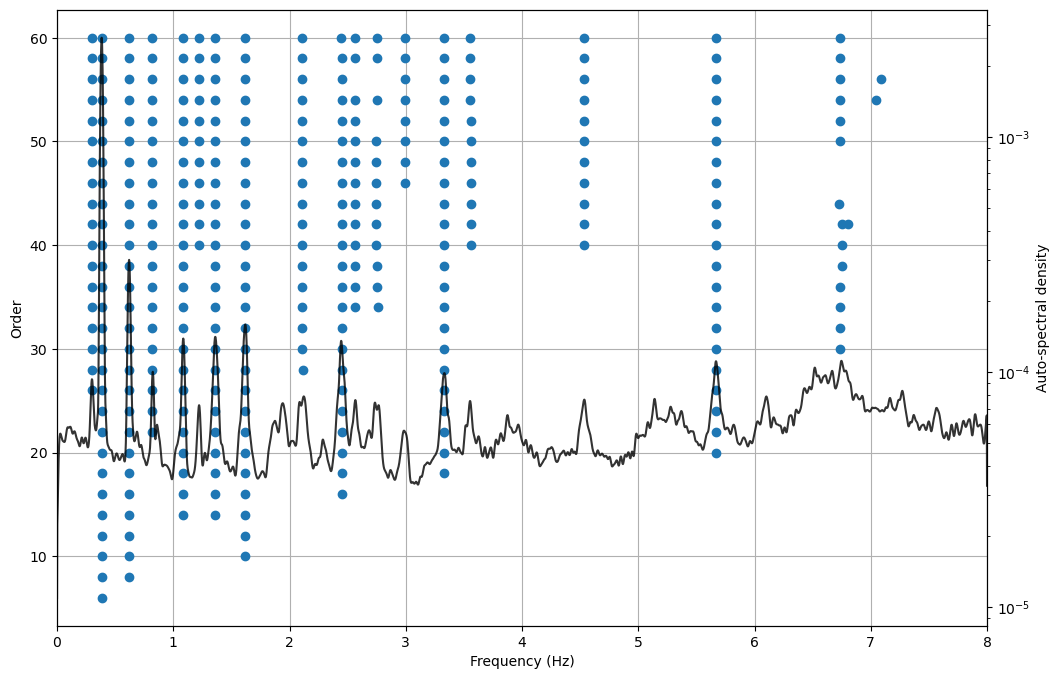

In [58]:
omega = np.abs(lambd_stab)
x = omega / (2 * np.pi)

fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Order")
ax1.plot(x, orders_stab, "o")
ax1.set_xlim(0, 8)
ax1.grid()

ax2 = ax1.twinx()
ax2.set_ylabel("Auto-spectral density")
ax2.plot(f, Sxx.real, color="black", alpha=0.8)
ax2.set_yscale("log")


In [59]:
pole_clusterer = koma.clustering.PoleClusterer(lambd_stab, phi_stab, orders_stab, min_cluster_size=6, min_samples=6,
                                               scaling={'mac':0.4, 'omega_n':0.8}, normalize_distances=False)

prob_threshold = 1.0

pole_clusterer.cluster()

outputs = pole_clusterer.postprocess(prob_threshold=prob_threshold, normalize_and_maxreal=True)
lambd_used, phi_used, orders_stab_used, group_ixs, all_single_ix, probs = outputs

xi_auto, omega_n_auto, phi_auto, order_auto, ixs_auto, probs_auto = koma.clustering.group_clusters(*outputs)

xi_mean = np.array([np.mean(xi_i) for xi_i in xi_auto])
fn_mean = np.array([np.mean(om_i) for om_i in omega_n_auto])/2/np.pi
xi_std = np.array([np.std(xi_i) for xi_i in xi_auto])
fn_std = np.array([np.std(om_i) for om_i in omega_n_auto])/2/np.pi

grouped_ixs = koma.clustering.group_array(all_single_ix, group_ixs)
grouped_phis = koma.clustering.group_array(phi_used, group_ixs, axis=1)
phi_mean = np.vstack([np.mean(phi_i, axis=1) for phi_i in grouped_phis]).T

In [60]:
print(fn_mean)
print(fn_mean.shape)


[0.29987586 0.38392749 0.38392754 0.61968128 0.61968229 0.82024069
 1.08754663 1.08755389 1.22047111 1.36068997 1.61720239 1.61746796
 2.11060634 2.11133213 2.44782999 2.56056514 2.74534385 2.99185436
 3.32954725 3.5572917  4.53543204 5.66778399 5.66796765 6.74479926]
(24,)


In [74]:
fn_mean_2 = np.delete(fn_mean, (2, 4, 7, 11, 13, 15, 21, 22, 23))
print(fn_mean_2.shape)

phi_mean_2 = np.delete(phi_mean, [2, 4, 7, 11, 13, 15, 21, 22, 23], axis=1)
print(phi_mean_2.shape)

(15,)
(57, 15)


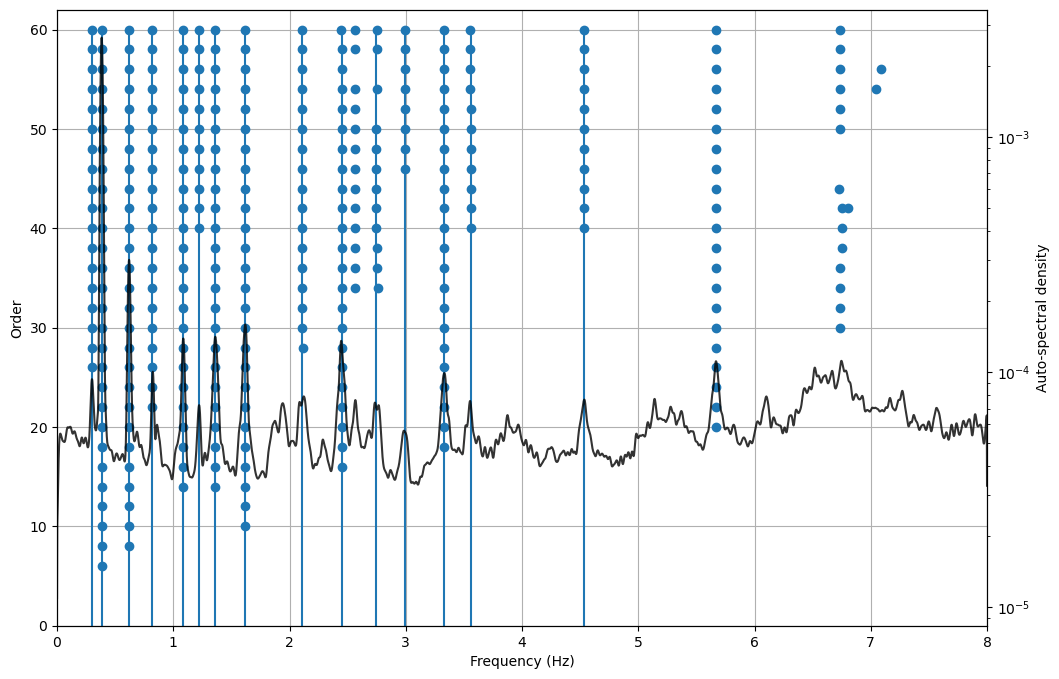

In [75]:
omega = np.abs(lambd_stab)
x = omega / (2 * np.pi)

fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Order")
ax1.plot(x, orders_stab, "o")
ax1.vlines(fn_mean_2, 0, 60)
ax1.set_xlim(0, 8)
ax1.set_ylim(0, 62)
ax1.grid()

ax2 = ax1.twinx()
ax2.set_ylabel("Auto-spectral density")
ax2.plot(f, Sxx.real, color="black", alpha=0.8)
ax2.set_yscale("log")

plt.savefig("./pictures/ssi_plot.svg")


In [76]:
indexed_freq_ssi = np.zeros((len(fn_mean_2), 2))
indexed_freq_ssi[:,0] = np.array([i for i in range(1, len(fn_mean_2) + 1)])
indexed_freq_ssi[:,1] = fn_mean_2
indexed_freq_ssi

array([[ 1.        ,  0.29987586],
       [ 2.        ,  0.38392749],
       [ 3.        ,  0.61968128],
       [ 4.        ,  0.82024069],
       [ 5.        ,  1.08754663],
       [ 6.        ,  1.22047111],
       [ 7.        ,  1.36068997],
       [ 8.        ,  1.61720239],
       [ 9.        ,  2.11060634],
       [10.        ,  2.44782999],
       [11.        ,  2.74534385],
       [12.        ,  2.99185436],
       [13.        ,  3.32954725],
       [14.        ,  3.5572917 ],
       [15.        ,  4.53543204]])

In [77]:
t1w = phi_mean_2[54:, :]
phi_mean_2 = np.append(phi_mean_2, t1w, 0)

ind = np.array([
    16.1, 16.2, 16.3,
    15.1, 15.2, 15.3,
    9.1,  9.2,  9.3,
    3.1,  3.2,  3.3,
    10.1, 10.2, 10.3,
    4.1,  4.2,  4.3,
    11.1, 11.2, 11.3,
    5.1,  5.2,  5.3,
    12.1, 12.2, 12.3,
    6.1,  6.2,  6.3,
    13.1, 13.2, 13.3,
    7.1,  7.2,  7.3,
    14.1, 14.2, 14.3,
    8.1,  8.2,  8.3,
    19.1, 19.2, 19.3,
    17.1, 17.2, 17.3,
    20.1, 20.2, 20.3,
    18.1, 18.2, 18.3,
    1.1,  1.2,  1.3,
    2.1,  2.2,  2.3,
])

In [78]:
indexed_modes_ssi = np.zeros((60, fn_mean_2.shape[0] + 1))

indexed_modes_ssi[:,0] = ind
indexed_modes_ssi[:,1:] = phi_mean_2.real

indexed_modes_ssi = indexed_modes_ssi[indexed_modes_ssi[:, 0].argsort()]

In [79]:
ordered_modes_ssi = indexed_modes_ssi[:, 1:]
ordered_modes_ssi.shape

(60, 15)

In [94]:
phi_csv = phi_mean_2[:57,:]
phi_csv.shape

(57, 15)

In [97]:
# Exporting .npy files for model updating
np.save("results/model updating/grenland_bridge_frequencies.npy", indexed_freq_ssi)
np.savetxt("results/model updating/grenland_bridge_frequencies.txt", indexed_freq_ssi)
np.save("results/model updating/grenland_bridge_modes.npy", ordered_modes_ssi)
np.savetxt("results/model updating/grenland_bridge_modes.txt", ordered_modes_ssi)

In [96]:
# Exporting .csv files for dynamo
df_freq = pd.DataFrame(fn_mean_2)
df_freq.to_csv("./results/dynamo/ssi_freq.csv", index=False, header=False, float_format='%.13f')

df_modes = pd.DataFrame(phi_csv.real)
df_modes.to_csv('./results/dynamo/ssi_modes.csv', index=False, header=False, float_format='%.13f')
